# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from shap import TreeExplainer, initjs, force_plot

# Wrangle Data

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/imdb/'

In [3]:
# Read New York City property sales data

# Define Wrangle Function
def wrangle(movies_filepath, names_filepath, ratings_filepath, principals_filepath):
    
    #Read in the 4 csv files
    df_movies = pd.read_csv(movies_filepath)
    df_names = pd.read_csv(names_filepath,
                           usecols=['imdb_name_id', 'name'])
    df_ratings = pd.read_csv(ratings_filepath)
    df_title_pricipals = pd.read_csv(principals_filepath)

    # Drop columns that are redundant or have more than 60% null values
    df_movies.drop(columns= ['year', 'original_title'], inplace=True)
    df_movies.drop(83917 ,axis=0, inplace=True)
    df_movies.dropna(axis=1, thresh=len(df_movies)*.6, inplace=True)
    df_ratings.dropna(axis=1, thresh=len(df_ratings)*.6, inplace=True)
    df_title_pricipals.dropna(axis=1, thresh=len(df_title_pricipals)*.6, inplace=True)
      
    #Convert to datetime object
    df_movies['date_published'] = pd.to_datetime(df_movies['date_published'])
    
    #Merge the CSV files
    df_movies_ratings = pd.merge(df_movies, df_ratings, on='imdb_title_id')
    df_names_principals = pd.merge(df_names, df_title_pricipals, on='imdb_name_id')
    df = pd.merge(df_movies_ratings, df_names_principals, on='imdb_title_id')
    df.set_index('date_published', inplace=True)
    
    # Drop high cardinality columns
    for col in df.columns:
        if df[col].nunique() > 80_000:
            df.drop(columns=col, inplace=True)
    
    #Drop Data Leakage Column
    df.drop(columns=['avg_vote'], inplace=True)
    
    return df

In [4]:
# Run Wrangle Function to read in CSV files
df = wrangle(DATA_PATH + 'imdb_movies.csv',
             DATA_PATH + 'imdb_names.csv',
             DATA_PATH + 'imdb_ratings.csv',
             DATA_PATH + 'imdb_title_principals.csv')

In [5]:
df_movies = pd.read_csv(DATA_PATH + 'imdb_movies.csv')
df_names = pd.read_csv(DATA_PATH + 'imdb_names.csv',
                           usecols=['imdb_name_id', 'name'])
df_ratings = pd.read_csv(DATA_PATH + 'imdb_ratings.csv')
df_title_pricipals = pd.read_csv(DATA_PATH + 'imdb_title_principals.csv')

In [6]:
df.shape

(835483, 54)

In [7]:
df.drop(columns=['ordering', 'category'], inplace=True)
df.shape

(835483, 52)

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(85845, 52)

# Split Data

In [9]:
# Split data into feature matrix and target vector
target = 'weighted_average_vote'

y = df[target]
X= df.drop(columns=target)

# Train on movies published before 2018, validate on 2018, test on after 2018
cutoff = 2018
mask = X.index.year < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[df.index.year == cutoff], y.loc[X.index.year == cutoff]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# Establish Baseline

In [10]:
y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_pred, y_train))
print(y_train.mean())

Baseline MAE: 0.9543148258663648
5.916089876695121


# Build Models

In [11]:
#Build Ridge Model

model_r = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        Ridge(alpha=20.0))
model_r.fit(X_train, y_train);

In [12]:
# Build XGB boosting regressor model

model_xgb= make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         XGBRegressor(n_jobs=-2))

# model_xgb.fit(X_train, y_train);

# Hyperparameter Tuning

In [13]:
params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__max_depth': range(2,11,2),
    'xgbregressor__alpha': range(2,11,2)
}

model_xgb_gs = GridSearchCV(model_xgb,
                            param_grid= params,
                            n_jobs= -2,
                            cv=10,
                            verbose=1)

model_xgb_gs.fit(X_train, y_train);

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [14]:
model_xgb_gs.best_score_

0.988025836849373

In [15]:
model_xgb_gs.best_params_

{'simpleimputer__strategy': 'mean',
 'xgbregressor__alpha': 2,
 'xgbregressor__max_depth': 4}

# Check Metrics

In [16]:
print('Ridge Training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge Validation MAE:', mean_absolute_error(y_val, model_r.predict(X_val)))

Ridge Training MAE: 0.07453938618209405
Ridge Validation MAE: 0.11939504835566946


In [18]:
print('XGBRegressor Training MAE:', mean_absolute_error(y_train, model_xgb_gs.predict(X_train)))
print('XGBRegressor Validation MAE:', mean_absolute_error(y_val, model_xgb_gs.predict(X_val)))

XGBRegressor Training MAE: 0.06429189509718868
XGBRegressor Validation MAE: 0.10874073136859216


# Feature Importances

In [31]:
coefficients = model_xgb_gs.best_estimator_.named_steps['xgbregressor'].feature_importances_
features = model_xgb_gs.best_estimator_.named_steps['ordinalencoder'].get_feature_names()
feature_importances = pd.Series(coefficients, index=features).sort_values(key=abs).tail(10)

Text(0.5, 1.0, 'Feature importances for XGBRegressor Model')

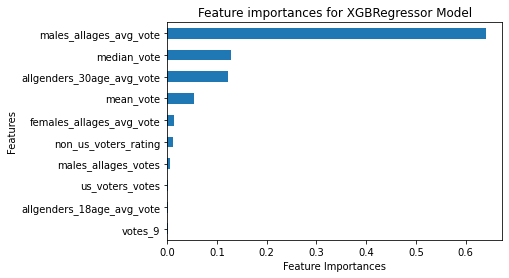

In [32]:
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Feature importances for XGBRegressor Model')

# Permutation Importances

In [34]:
perm_imp = permutation_importance(model_xgb_gs,
                                  X_val,
                                  y_val,
                                  n_jobs=-2,
                                  random_state=42)

In [35]:
data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index=X_val.columns)

Text(0.5, 1.0, 'Permutation importances for XGBRegressor Model')

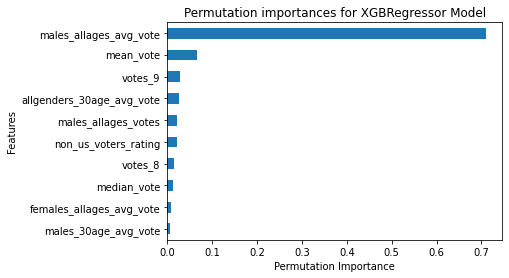

In [36]:
data['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation importances for XGBRegressor Model')

# 1 Feature Partial Dependence Plot

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='non_us_voters_rating'>})

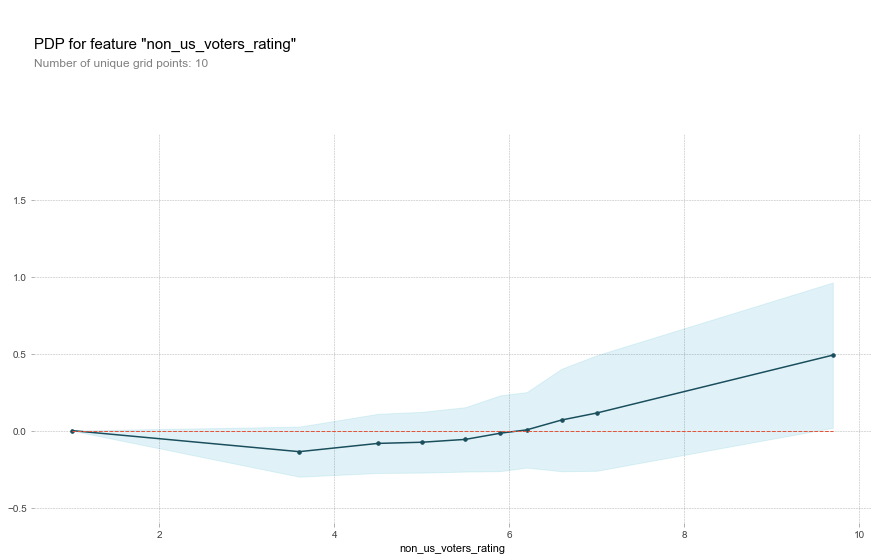

In [38]:
feature = 'non_us_voters_rating'

isolate = pdp_isolate(model = model_xgb_gs,
                      dataset = X_val,
                      model_features = X_val.columns,
                     feature=feature)

pdp_plot(isolate, feature_name=feature)